# **EDA, Data Preparation & Feature Engineering**

**✨ Cross‑Environment Compatibility Statement (Polished Version)**

This hands‑on demo was built and tested in Microsoft Fabric, but every step uses standard Apache Spark APIs. That means you can run the exact same code in any Spark‑compatible environment, including Databricks, Synapse Spark, AWS EMR, Google Dataproc, or a local Spark cluster. No Fabric‑specific libraries or features are required.

As long as your environment supports:
- Apache Spark (PySpark)
- Standard DataFrame operations
- Basic file I/O to a supported storage location

In [1]:

# Replace the path with your file location in the Lakehouse:
csv_path = "Files/csv/ml/regression_housing.csv"

# Read with header, infer schema; we'll fix types afterwards to be safe.
raw_data_df = (
    spark.read
         .option("header", "true")
         .option("inferSchema", "true")
         # Treat empty strings as nulls to simplify downstream casting
         .option("nullValue", "")
         .csv(csv_path)
)

display(raw_data_df.limit(5))


StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 3, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, d529ff03-26bc-4995-894c-204ca6e8304d)

In [2]:
# Pretty tree view of the schema
raw_data_df.printSchema()

StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 4, Finished, Available, Finished)

root
 |-- city: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- beds: integer (nullable = true)
 |-- baths: double (nullable = true)
 |-- sqft: double (nullable = true)
 |-- built_year: integer (nullable = true)
 |-- lot_acres: double (nullable = true)
 |-- has_garage: integer (nullable = true)
 |-- has_renovation: integer (nullable = true)
 |-- price: integer (nullable = true)



#### **Quick completeness check (missing values per column)**
- **Goal:** Get min/max/mean/std for key numeric columns.

**What to look for:**
- Ranges that make sense (e.g., sqft ~ 500–6000, lot_acres small but skewed).
- Check built_year spread and price heavy tails.

In [3]:
# raw_data_df.describe().show()

# More robust summary (includes percentiles for numeric cols)
display(raw_data_df.summary())

StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, a072352f-33b6-4b11-bbb7-9795097956c6)

####  **Validate the missing‑value information observed in the summary() output**
- This completeness check confirms our earlier findings: the columns baths, sqft, and lot_acres each contain exactly 30 missing values, while all other fields including the target price have zero missing entries. This validates that only these three features require imputation, and the rest of the dataset is fully complete.

In [4]:
from pyspark.sql import functions as F
cols = raw_data_df.columns

missing_counts = raw_data_df.select([
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in cols
])

missing_counts.show()

StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 6, Finished, Available, Finished)

+----+------------+----+-----+----+----------+---------+----------+--------------+-----+
|city|neighborhood|beds|baths|sqft|built_year|lot_acres|has_garage|has_renovation|price|
+----+------------+----+-----+----+----------+---------+----------+--------------+-----+
|   0|           0|   0|   30|  30|         0|       30|         0|             0|    0|
+----+------------+----+-----+----+----------+---------+----------+--------------+-----+



#### **Handling Missing Values (Imputation Step)**
- **Goal:** See where you need imputation.

What to look for:
- In this synthetic dataset, ~3% missing in sqft, lot_acres, baths is expected.
- No missing in target price ideally.

In [5]:
from pyspark.sql import functions as F

# Columns to impute
target_cols = ["sqft", "lot_acres", "baths"]

# 1) Cast target columns to numeric (DoubleType) if needed
df_num = raw_data_df.select([
    F.col(c).cast("double").alias(c) if c in target_cols else F.col(c)
    for c in raw_data_df.columns
])

# 2) Compute medians using approxQuantile
#    relativeError=0.001 gives a tight approximation while staying efficient
medians = {}
for c in target_cols:
    # Handle the case where column is all nulls (approxQuantile returns empty)
    quantiles = df_num.stat.approxQuantile(c, [0.5], 0.001)
    medians[c] = quantiles[0] if quantiles else None

# Optional: if a column has no non-null values, fall back to 0 or mean
fallbacks = {}
for c in target_cols:
    if medians[c] is None:
        # fallback to mean; if mean is also None, fallback to 0
        mean_val = df_num.select(F.mean(F.col(c))).first()[0]
        fallbacks[c] = mean_val if mean_val is not None else 0.0

# Combine medians with fallbacks
fill_values = {c: (medians[c] if medians[c] is not None else fallbacks[c]) for c in target_cols}

# 3) Impute nulls
df_imputed = df_num.na.fill(fill_values)

# Preview results
display(df_imputed.summary())  # quick sanity check


StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, e39561f6-b94a-44bb-b67a-30815cecc8d0)

#### **Uncovering Distribution Patterns to Understand Data Structure**

**What do the two outputs from the above scripts tell you? Provide a summary.**

**Cities (first output):**
- **Jacksonville and Idaho Falls** have the highest median prices, meaning they are the most expensive markets in your dataset.
- Cities like **Arlington and Boston** have lower medians.
- **IQR** values differ widely, showing that some cities have more price variability than others.

**Neighborhoods(second output):**
- **Downtown** has the highest median and the largest IQR, confirming a premium, diverse-price market.
- **Suburban** is mid‑priced.
- **Rural** is the least expensive with the smallest price spread.

In [6]:
from pyspark.sql import functions as F

# Median (p50) and IQR per city
city_stats = df_imputed.groupBy("city").agg(
    F.expr("percentile(price, 0.5)").alias("median_price"),
    F.expr("percentile(price, 0.25)").alias("p25_price"),
    F.expr("percentile(price, 0.75)").alias("p75_price"),
    F.count("*").alias("n")
).withColumn("IQR_price", F.col("p75_price") - F.col("p25_price")) \
 .orderBy(F.desc("median_price"))
display(city_stats)

# Median (p50) and IQR per neighborhood
nhood_stats = df_imputed.groupBy("neighborhood").agg(
    F.expr("percentile(price, 0.5)").alias("median_price"),
    F.expr("percentile(price, 0.25)").alias("p25_price"),
    F.expr("percentile(price, 0.75)").alias("p75_price"),
    F.count("*").alias("n")
).withColumn("IQR_price", F.col("p75_price") - F.col("p25_price")) \
 .orderBy(F.desc("median_price"))
display(nhood_stats)

StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 7c12f486-8098-4cc2-9d50-c0741f41d100)

SynapseWidget(Synapse.DataFrame, 5bb3b474-39a5-4225-8828-2b08180ddd2c)

#### **Finding Robust Outliers in Pricing and Property Metrics**

In [7]:
def iqr_bounds(col):
    q = df_imputed.approxQuantile(col, [0.25,0.75], 0.001)
    Q1, Q3 = q[0], q[1]
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return lower, upper

rows = []
for c in ["price","sqft","lot_acres","baths","beds"]:
    lower, upper = iqr_bounds(c)
    cnt_low = df_imputed.filter(F.col(c) < lower).count()
    cnt_high = df_imputed.filter(F.col(c) > upper).count()
    rows.append((c, lower, upper, cnt_low, cnt_high))

out_df = spark.createDataFrame(rows, ["column","lower_bound","upper_bound","num_below","num_above"])
display(out_df.orderBy(F.desc("num_above")))

StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 9, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 153208e3-bcd8-4ac0-8ff4-8013f3775c1e)

#### **Frequency tables**
- **Frequency tables** are essential because they show how often each unique value appears in a categorical or discrete feature, helping you quickly understand the distribution, dominance, and balance of categories in the dataset. 
- They make it easy to spot issues such as rare categories, class imbalance, unusual patterns, or unexpected entries, all of which directly impact feature engineering, encoding decisions, sampling strategies, and model performance.

In [8]:
# Frequency tables
for c in ["city","neighborhood","has_garage","has_renovation"]:
    freq = df_imputed.groupBy(c).count().orderBy(F.desc("count"))
    display(freq)

StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 10, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, aba8a1fc-97be-4401-aa74-83e4c9e8a6bb)

SynapseWidget(Synapse.DataFrame, e2e030e3-90f8-4732-a350-405a37c2999f)

SynapseWidget(Synapse.DataFrame, ce5ddb17-cad8-4fd9-bc4e-dba5163d9351)

SynapseWidget(Synapse.DataFrame, ef9360b1-a7ea-4f08-b9ce-4827a9c5df46)

#### **Price by city/neighborhood (boxplot via pandas for visualization)**
- When it comes to outliers, one of the best ways to quickly spot areas with unusually high or inconsistent values is to rely on boxplots, because they clearly show the median, IQR range, and any points that fall outside the whiskers.

StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 11, Finished, Available, Finished)

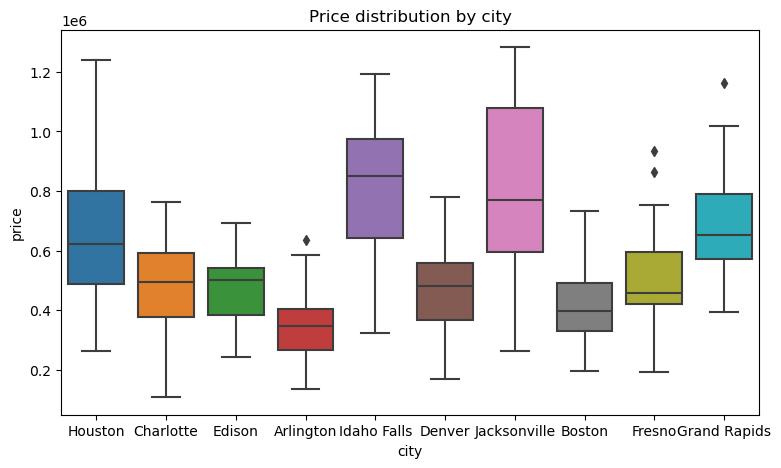

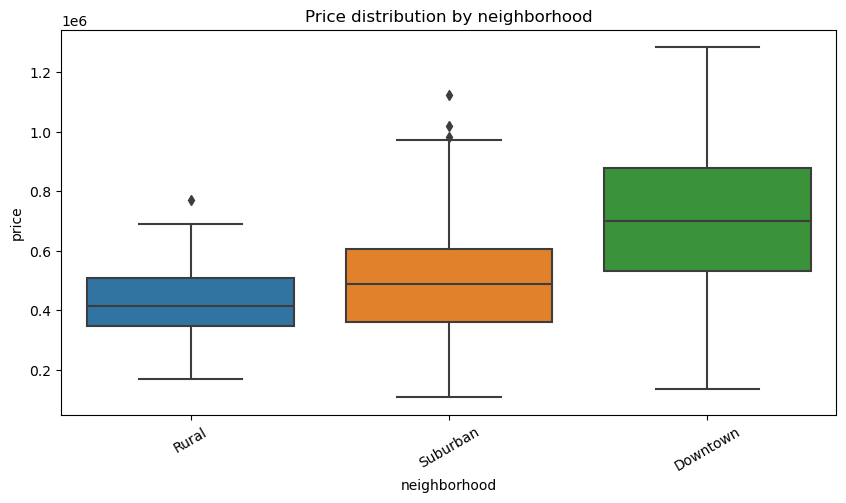

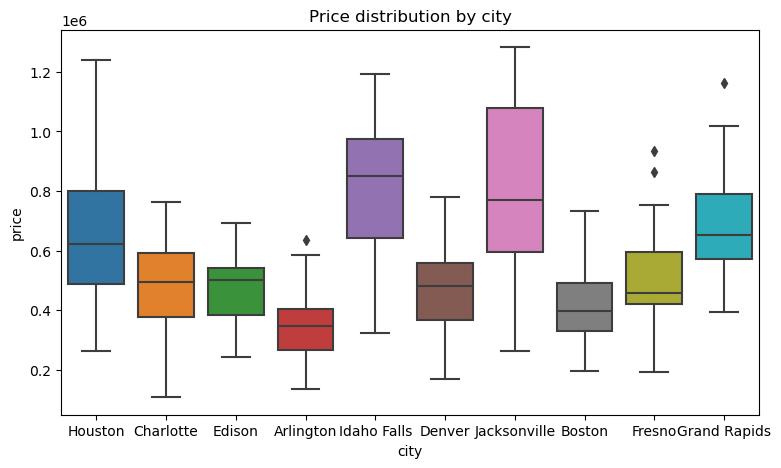

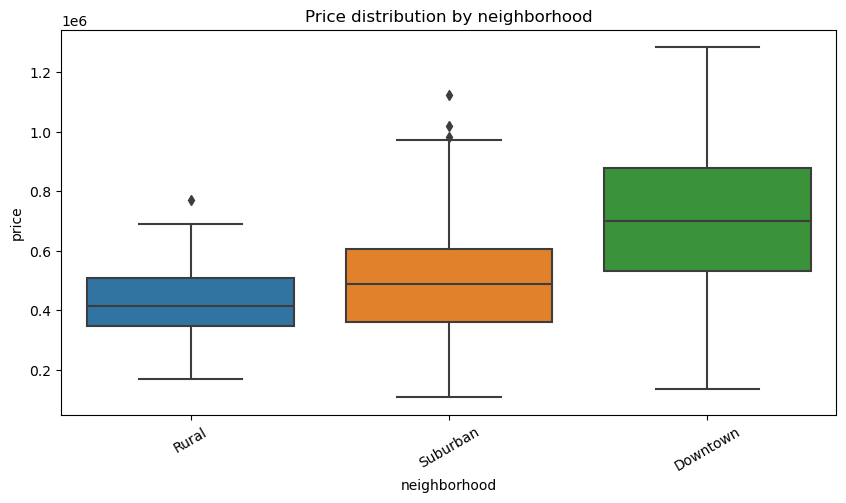

In [9]:
# Price by city/neighborhood (boxplot via pandas for visualization)
pdf = df_imputed.select("city","neighborhood","price").sample(0.2, seed=7).toPandas()
import seaborn as sns, matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(data=pdf, x="city", y="price")
ax.set_title("Price distribution by city")
display(fig)

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=pdf, x="neighborhood", y="price")
ax.set_title("Price distribution by neighborhood")
ax.tick_params(axis='x', rotation=30)
display(fig)

#### **Analyzing Feature Relationships Through Correlation**
**Takeaway:** These codes will generate a heatmap shows that sqft is the most important numeric driver of price here, while other features have very small linear relationships.

**Each cell shows how strongly two variables move together.
Values range from –1 to +1.:**
- **Red** = positive correlation: when one goes up, the other tends to go up.
- **Blue** = negative correlation: when one goes up, the other tends to go down.
- **White/gray** = little or no relationship.


**Key Insights From This Heatmap:**
- **Square footage (sqft)** has the strongest positive correlation with price (~0.33).
→ Bigger homes tend to be more expensive.
- Beds, baths, lot size, built year, garage, renovation all show weak correlations with price (near 0).
→ In this dataset, they do not strongly influence price on their own.
- Diagonal = 1.0 because every variable is perfectly correlated with itself.

StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 12, Finished, Available, Finished)

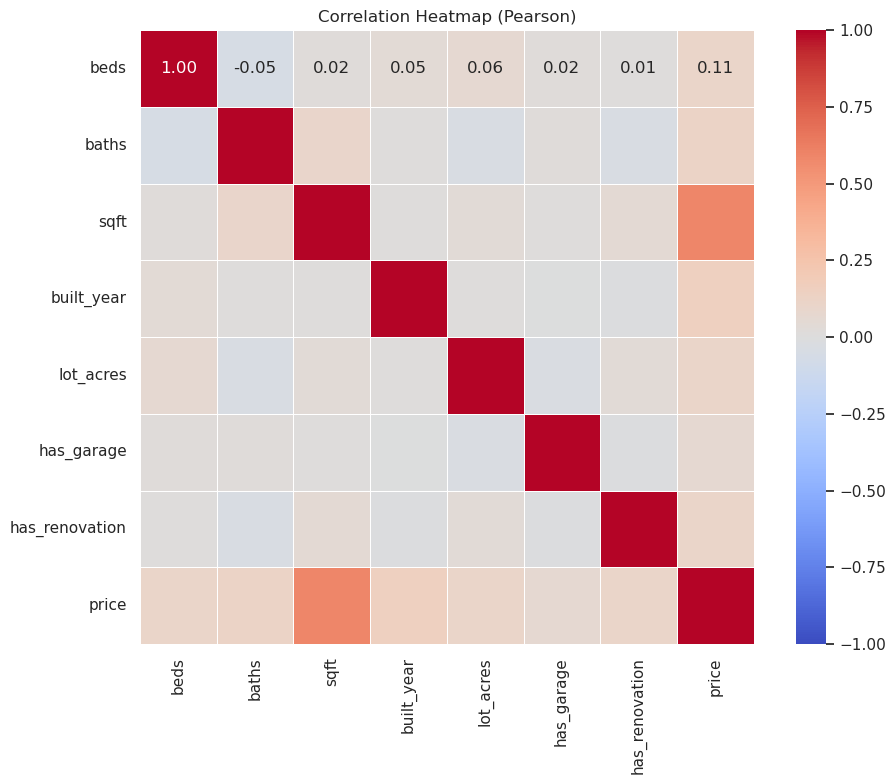

In [10]:

# Simple Pandas/Seaborn approach (for small datasets)
import seaborn as sns
import matplotlib.pyplot as plt

pdf = (df_imputed
       .select("beds", "baths", "sqft", "built_year", "lot_acres",
               "has_garage", "has_renovation", "price")
       .toPandas())

corr_mat = pdf.corr(method="pearson")  # DataFrame of correlations

plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.0)
sns.heatmap(
    corr_mat,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1, vmax=1,
    square=True,
    linewidths=.5
)
plt.title("Correlation Heatmap (Pearson)")
plt.tight_layout()
plt.show()

#### **Feature Engineering: Preparing Data for Machine Learning Success**

In [11]:
display(df_imputed.limit(5))

StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 13, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 1adf4727-f068-4cf7-8050-15c2e55fb4e3)

In [12]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

cat_cols = ["city", "neighborhood"]

# Convert only the needed columns to pandas to avoid memory blowups
pdf_cat = df_imputed.select(cat_cols).toPandas()

enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # use sparse_output=True for large data
X_cat = enc.fit_transform(pdf_cat)
oh_cols = enc.get_feature_names_out(cat_cols)

# If you want the full encoded pandas DataFrame:
pdf_full = df_imputed.toPandas()
df_oh = pd.concat(
    [pdf_full.drop(columns=cat_cols).reset_index(drop=True),
     pd.DataFrame(X_cat, columns=oh_cols)],
    axis=1
)

print("Original columns:", len(pdf_full.columns))
print("One-hot encoded columns:", len(df_oh.columns))

display(df_oh.head(5))

StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 14, Finished, Available, Finished)

Original columns: 10
One-hot encoded columns: 21


SynapseWidget(Synapse.DataFrame, 7df6cede-37c5-40df-9361-82fd47b99cae)

#### **Feature scaling**
- **Feature scaling** ensures that all input features contribute equally to the model by putting them on a similar scale. Without it, features with larger ranges (like square footage or lot size) can dominate distance-based models or slow down gradient-based optimization. Scaling improves model accuracy, convergence speed, and interpretability.

The output below shows that **only the numeric features were standardized using above scripts, which is why columns like beds, baths, sqft, built_year, and lot_acres now appear as scaled values centered around zero**. As a result, the dataset looks much more balanced, the wide‑range numeric features are now on a similar scale, while the one‑hot encoded city columns remain as simple 0/1 indicators. This is exactly the behavior we expect from the script.

Therefore, the dataset is not a problem, we intentionally standardized only the numeric features that needed scaling, and left the one‑hot encoded columns untouched because scaling them would distort their meaning.


In [13]:
import numpy as np
from sklearn.preprocessing import StandardScaler

target_col = "price"  # label
feature_cols = [c for c in df_oh.columns if c != target_col]

# Numeric columns to scale (skip one-hot 0/1 by nunique==2)
num_cols = [
    c for c in feature_cols
    if np.issubdtype(df_oh[c].dtype, np.number) and df_oh[c].nunique() > 2
]
oh_cols = [c for c in feature_cols if c not in num_cols]  # keep as-is

# Fit scaler on TRAIN ONLY in a real pipeline; for demo we fit on all
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(df_oh[num_cols])

# Create the final scaled dataframe
df_scaled = df_oh.copy()
df_scaled[num_cols] = scaler.transform(df_scaled[num_cols])

display(df_scaled.head(5))

StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 15, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f994f53c-ab44-4760-a71e-3486c25a0cc5)

In [33]:
out_dir = "Files/csv/ml/cleaned/regression_housing_cleaned"

df_scaled_spark = spark.createDataFrame(df_scaled)


(df_scaled_spark
    .coalesce(1)  # force a single output file
    .write
    .mode("overwrite")
    .option("header", True)
    .csv(out_dir)
)


StatementMeta(, cb2db2c5-fd7f-4195-9990-33ddb8d14c69, 35, Finished, Available, Finished)